In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
from math import pi as π

import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from genjax import gensp, normal, uniform

sns.set_theme(style="white")

# Pretty printing.
console = genjax.console(width=70)

# Reproducibility.
key = jax.random.PRNGKey(314159)
def slash(key, n):
    ks = jax.random.split(key, n+1)
    return ks[0], jnp.array(ks[1:])


Let's start by defining a model generative program. This example is from [Alex Lew's 2020 LAFI talk on a language called MetaPPL](https://popl20.sigplan.org/details/lafi-2020/14/MetaPPL-Inference-Algorithms-as-First-Class-Generative-Models).

In [3]:
@genjax.Static
def model():
    x = normal(0.0, 10.0) @ "x"
    y = normal(0.0, 10.0) @ "y"
    z = normal(x**2 + y**2, 1.0) @ "z"
    return z

In [5]:
key, sub_keys = slash(key, 300)
trs = jax.vmap(model.simulate, in_axes=(0, None))(sub_keys, ())
chm = trs.strip()

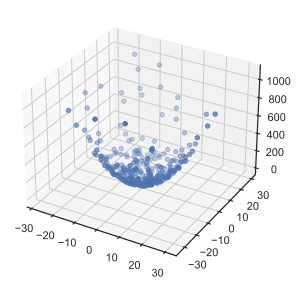

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(chm["x"], chm["y"], chm["z"])
plt.show()

When we use `gensp.chm_dist` (which is shorthand for `gensp.ChoiceMapDistribution`) - we're creating a new generative function whose internal proposal `q` can be changed.

In [7]:
gensp_model = gensp.chm_dist(model, selection=genjax.select("x", "y"), custom_q=None)
gensp_model

AttributeError: module 'genjax.gensp' has no attribute 'chm_dist'

Above, we're keeping the default internal proposal `q` by not providing a `custom_q`. This means that `gensp_model` inherits `q` from `model`.

The resulting `gensp_model` object is something called a `ChoiceMapDistribution` - it's an estimated distribution over the random choices at the addresses we pass in via `selection`.

We specified `"x"` and `"y"` - which means we are asking for a distribution which is the **marginal** of the full joint of `model`.

$$
P(x, y) = \int P(x, y, z) \ dz
$$

As we know, this is the source of the intractability of Bayesian inference in the first place! So how do we get around this?

In [8]:
key, tr = gensp_model.simulate(key, ())
tr

NameError: name 'gensp_model' is not defined

Another way to produce an estimated density is to condition a normalized distribution (producing an unnormalized one), and then estimate the normalization constant.

GenSP provides a way to express these densities using `gensp.Target`.

In [ ]:
constraint = genjax.choice_map({"z": 4.0})
constraint

In [ ]:
target = gensp.target(model, (), constraint)
target

A `Target` is an unnormalized distribution. The standard inference library in GenSP exposes inference algorithms which are themselves estimated densities, whose interfaces accept `Target` instances and perform estimated normalization.

In [ ]:
gensp_is = gensp.importance(50, None)
gensp_is

The default variant of `gensp.importance` utilizes sampling importance resampling with no custom proposal. Let's examine the quality of the posterior approximation.

In [ ]:
key, sub_keys = slash(key, 1000)
_, tr = jax.jit(jax.vmap(gensp_is.simulate, in_axes=(0, None)))(sub_keys, (target,))
chm = tr.get_retval()
chm

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
circle = plt.Circle((0, 0), 2.0, color="k", fill=False, lw=3)
ax.scatter(chm["x"], chm["y"], marker=".")
ax.add_artist(circle)

We can improve the quality of the approximation by providing a custom proposal.

In [ ]:
@genjax.Static
def custom_q(target):
    chm = target.constraints
    z = chm["z"]
    θ = uniform(0.0, 2 * π) @ "θ"
    x = normal(jnp.sqrt(z) * jnp.cos(θ), 0.2) @ "x"
    y = normal(jnp.sqrt(z) * jnp.sin(θ), 0.2) @ "y"

When run within the sampling importance resampling routine, the custom proposal is allowed to inspect the observed data (here, `chm`).

Note that `custom_q` samples auxiliary randomness for the `"θ"` address - to correctly define the importance weight density ratio, we need to marginalize out `"θ"`.

In [ ]:
gensp_custom_q = gensp.chm_dist(custom_q, selection=genjax.select("x", "y"))

In [ ]:
gensp_is = gensp.importance(50, gensp_custom_q)
gensp_is

In [ ]:
key, sub_keys = slash(key, 1000)
_, tr = jax.jit(jax.vmap(gensp_is.simulate, in_axes=(0, None)))(sub_keys, (target,))
chm = tr.get_retval()
chm

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
circle = plt.Circle((0, 0), 2.0, color="k", fill=False, lw=3)
ax.scatter(chm["x"], chm["y"], marker=".")
ax.add_artist(circle)

For both variants, we can estimate the log evidence and compare the value - the conditional log evidence ratio is often used for Bayesian model selection.

## Trace types for absolute continuity diagnosis

In the preceding sections, we were careful to identify exactly what subsets of random variables we wished to target with proposals and we lined addresses up accordingly. However, as the complexity of an estimated density tower increases - it would be useful to have automated tooling to check for support mismatches.

GenJAX generative functions support a form of gradual typing based upon [Lew et al, 2020](https://dl.acm.org/doi/10.1145/3371087) - providing a conservative representation of the support of the distribution which a generative function represents.

In [ ]:
model.get_trace_type()

In [ ]:
custom_q.get_trace_type(target)

What happens if we transform `custom_q` to internally marginalize `"θ"`?

In [ ]:
gensp_custom_q.get_trace_type(target)

There's an interface for trace types called `on_support`, which checks if a trace type is on the support of another trace type.

In [ ]:
t1 = gensp_custom_q.get_trace_type(target)
t2 = model.get_trace_type()
check, mismatch_tree = t1.on_support(t2)
mismatch_tree

This interface returns two values: the first is a `bool` indicating if the first is on the support of the second, and the second is a "mismatch" tree which shows what addresses violate the check.

Every address which violates the check gets a `tuple` showing the trace type for the first type against the second type at that address - above, we see that the proposal doesn't provide a choice at `"z"`, the first element is `None` in the tuple.

GenJAX's GenSP implementation takes advantage of this gradual type system to perform static support checks at compile time, and return errors if mismatches occur. Observe:

In [ ]:
@genjax.Static
def no_match(target):
    θ = normal(0.0, 1.0) @ "θ"


try:
    gensp.static_check_supports(target, no_match)
except Exception as e:
    console.print(e)